In [ ]:
%%capture
!pip install kneed mlflow kneebow pandas==0.24.2

In [ ]:
!pip install --upgrade wandb
!wandb login e4eae987f6b018b0dcddf9e69b6170993b2f6f60
import tensorflow.keras
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 112kB 16.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=e2f5c3ee7e5ed8f68141c40ba18444a3ea3c171c2cb1bcc69e5a51767c20ef17
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=8aa37f080c1b90c6ad5baa15e98f3cb08926ca97100a9a04cc1976851dcabe2c
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=86cc1eeaace12c435b0a0ad02b334cabd1304c5a5f849395478095c58fc729e5
  Stored in directory: /root/.cache/pip/wheels/a8

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/WORK/ML/Neurosteer/ML2020"

/content/drive/My Drive/WORK/ML/Neurosteer/ML2020


In [ ]:
%%capture
!rm -rf ngrok*.zip
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [ ]:
!mlflow ui > /dev/null 2>&1 &

In [ ]:
get_ipython().system_raw('./ngrok http 5000 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c24d2fe485c1.ngrok.io


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7654521358926327280
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6523531109115780485
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15702751304642457288
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150664704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16808296917647352363
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
!rm -rf ml2020
!git clone https://hershkoy@bitbucket.org/hershkoy/ml2020.git

Cloning into 'ml2020'...
remote: Counting objects: 485, done.
remote: Compressing objects: 100% (482/482), done.
remote: Total 485 (delta 258), reused 0 (delta 0)
Receiving objects: 100% (485/485), 2.47 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [ ]:
import pickle
import mlflow
import mlflow.tensorflow

import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error,adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

from tensorflow.keras.layers import LSTM,Bidirectional

import tensorflow as tf
import numpy as np
import pandas as pd
from collections import namedtuple


import os
import sys
import glob
import matplotlib.pyplot as plt

sys.path.insert(0,os.path.join(os.getcwd(),"ml2020/code/lib"))

import Vizualization
import experiment_utils as utils

viz = Vizualization.Vizualization()


/usr/local/lib/python3.6/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()



In [ ]:
infile = open('data/sleep_data/df_features_test_env_labeled.pkl','rb')
df_labeled = pickle.load(infile)
infile.close()

infile = open('data/sleep_data/df_labels_test_env.pkl','rb')
labeled_data = pickle.load(infile)
infile.close()

sessionNames_list = df_labeled.index.levels[0]
print(sessionNames_list)

Index(['2019-07-17-21-39-40', '2019-07-22-19-34-39', '2019-07-22-19-58-50',
       '2019-07-22-20-10-03', '2019-07-23-19-32-23', '2019-07-23-23-10-19'],
      dtype='object', name='sessionName')


In [ ]:
class FitCallback(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.adjusted_rand = []

    def on_epoch_end(self, epoch, logs=None):
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        ari = adjusted_rand_score(predict,targ)
        self.adjusted_rand.append(ari)
        print(f"epoch {epoch}: logs {logs}, ARI:{ari}")
        return

    #def on_train_batch_end(self, batch, logs=None):
    #    print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    #def on_test_batch_end(self, batch, logs=None):
    #    print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))



In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def custom_loss(y_true,y_pred):
  y_pred = ops.convert_to_tensor_v2(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  ret = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, axis=-1)
  #print(f"y_true:{y_true.numpy()}")
  #print(f"y_pred:{y_pred.numpy()}")
  #print(f"ret:{ret.numpy()}")
  return ret**2

y_true = [1, 1]
y_pred = [[0.05, 0.95, 0], [0.8, 0.1, 0.1]]
loss = custom_loss(y_true, y_pred)
assert loss.shape == (2,)
loss.numpy()

array([2.6310175e-03, 5.3018980e+00], dtype=float32)

In [ ]:
#mlflow.set_experiment("plot curves")
#mlflow.start_run()

wandb_enable = False

hyperparameter_defaults = dict(
  dropout = 0.3,
  lstm_size = 128,
  clip_val = 0.5,
  window_size = 15,
  epochs = 40,
)

if (wandb_enable):
  wandb.init(project="ml2020",config=hyperparameter_defaults,name="bilstm128x2,clip=0.5,drop=0.3,adam,llo=0")
  config = wandb.config
else:
  config = namedtuple("myobj", hyperparameter_defaults.keys())(*hyperparameter_defaults.values())


window_size = config.window_size

with tf.device("/gpu:0"):

  x_data = np.empty((0, window_size, 122), int)
  y_data = np.empty((0, 1), int)

  for idx in range(len(sessionNames_list)):

      sessionName = sessionNames_list[idx]
      print(f"sessionName:{sessionName}", end =" ") 

      samples = utils.filter_by(df_labeled,{'sessionName' : [sessionName]})
      timestamp = samples.reset_index().timestamp
      samples = samples.get_values()
      samples = pd.DataFrame(data=samples,index=timestamp)

      print(f"data:{samples.shape}", end =" ") 
      

      labels = utils.filter_by(labeled_data,{'sessionName' : [sessionName]}).reset_index()
      hypno = labels.y
      hypno_ts = labels.timestamp
      hypno.index = list(labels.timestamp)

      hypno_val = hypno.replace(['U','W','R','N2','N3'],[0,1,2,3,4])
    
      print(f"hypno_val:{len(hypno_val)}")

      start = np.round((hypno_ts[0]-timestamp[0])/(window_size*1000)).astype(int)
      if (start>0):    
          samples=samples[start:]
          
      if (samples.shape[0]/window_size!=0):
          end = int(samples.shape[0]/window_size)*window_size
          samples=samples[:end]
          
      samples['ind'] = np.arange(samples.shape[0])/10000 #10K, just a big number
      samples = samples.to_numpy()
      samples = samples.reshape(int(samples.shape[0]/window_size),window_size,122)
      
      if (samples.shape[0]>hypno_val.shape[0]):
          end = hypno_val.shape[0]
          samples=samples[:end]
          
      x_data = np.vstack((x_data,samples))
      y_data = np.vstack((y_data,hypno_val.to_numpy().reshape(-1, 1)))
      
      print(f"s0:{samples.shape}")
      
      

  #%%

  n_classes = len([0,1,2,3,4])

  tf.compat.v1.keras.backend.clear_session()

  inputs = tf.keras.layers.Input((window_size, 122))

  conv1 =  tf.keras.layers.Conv1D(16, kernel_size=8, padding='SAME')
  res = conv1(inputs)

  res = Bidirectional(LSTM(config.lstm_size,dropout=config.dropout,return_sequences=True))(res)
  res = Bidirectional(LSTM(config.lstm_size,dropout=config.dropout))(res)

  #res = LSTM(config.lstm_size,dropout=config.dropout)(inputs)
  
  res = tf.keras.layers.Dense(config.lstm_size, activation=tf.nn.leaky_relu)(res)
  res = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(res)
  
  model = tf.keras.models.Model(inputs, res)

  #x_train, x_test, y_train, y_test = train_test_split(x_data,
  #                                                    y_data,
  #                                                    test_size=0.15,shuffle=False)
  
  split = int(len(x_data)*0.15)
  x_train = x_data[split:,:]
  y_train = y_data[split:,:]
  x_test = x_data[:split,:]
  y_test = y_data[:split,:]



  #mlflow.tensorflow.autolog()


  #optimizer = tf.keras.optimizers.RMSprop(clipvalue=config.clip_val)
  optimizer = tf.keras.optimizers.Adam(clipvalue=config.clip_val)

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', baseline=1.0)

  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',  #custom_loss
                metrics=['accuracy'])

  #model.run_eagerly = True
  
  model.fit(x_train,
            y_train,
            validation_data=(x_test, y_test),
            batch_size=8,
            #callbacks=[LossAndErrorPrintingCallback()],
            #callbacks=[WandbCallback()],
            #callbacks=[es], #,FitCallback()],
            epochs=config.epochs)

#mlflow.end_run()



sessionName:2019-07-17-21-39-40 data:(16621, 121) hypno_val:1107
s0:(1107, 15, 122)
sessionName:2019-07-22-19-34-39 data:(29394, 121) hypno_val:1958
s0:(1958, 15, 122)
sessionName:2019-07-22-19-58-50 data:(14767, 121) hypno_val:983
s0:(983, 15, 122)
sessionName:2019-07-22-20-10-03 data:(16984, 121) hypno_val:1131
s0:(1131, 15, 122)
sessionName:2019-07-23-19-32-23 data:(31603, 121) hypno_val:2105
s0:(2105, 15, 122)
sessionName:2019-07-23-23-10-19 data:(15993, 121) hypno_val:1065
s0:(1065, 15, 122)
Epoch 1/40
888/888 [==============================] - 24s 27ms/step - loss: 1.2350 - accuracy: 0.4382 - val_loss: 1.4328 - val_accuracy: 0.3690
Epoch 2/40
888/888 [==============================] - 23s 26ms/step - loss: 1.1244 - accuracy: 0.5137 - val_loss: 1.3588 - val_accuracy: 0.4225
Epoch 3/40
888/888 [==============================] - 23s 26ms/step - loss: 1.0585 - accuracy: 0.5519 - val_loss: 1.2600 - val_accuracy: 0.4864
Epoch 4/40
888/888 [==============================] - 23s 26ms/ste

In [ ]:
x_data[]

((8349, 15, 122), (8349, 1))

In [ ]:
idx = 0

sessionName = sessionNames_list[idx]

labels = utils.filter_by(labeled_data,{'sessionName' : [sessionName]}).reset_index()
hypno_real = labels.y

samples = utils.filter_by(df_labeled,{'sessionName' : [sessionName]})
timestamp = samples.reset_index().timestamp
samples = samples.get_values()
samples = pd.DataFrame(data=samples,index=timestamp)

if (samples.shape[0]/window_size!=0):
    end = int(samples.shape[0]/window_size)*window_size
    samples=samples[:end]

samples['ind'] = np.arange(samples.shape[0])/10000 #10K, just a big number
samples = samples.to_numpy()
samples = samples.reshape(int(samples.shape[0]/window_size),window_size,122)

prediction = model.predict(samples)
hypno_pred = np.argmax(prediction, axis=1)
hypno_pred = pd.Series(data=hypno_pred,index=np.arange(len(hypno_pred)))
hypno_pred_val = hypno_pred.replace([0,1,2,3,4],['U','W','R','N2','N3'])

plt.figure(figsize=(8, 8))
plt.suptitle(f"Session #{idx}")
ax = plt.subplot(2, 1, 1)
viz.plot_labeled_hypnogram(hypno_real,title="real",ax=ax)
ax = plt.subplot(2, 1, 2)
viz.plot_labeled_hypnogram(hypno_pred_val,title="pred",ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(hypno_real,hypno_pred_val[1:])

0.1967121241254265

0.28015566164277694


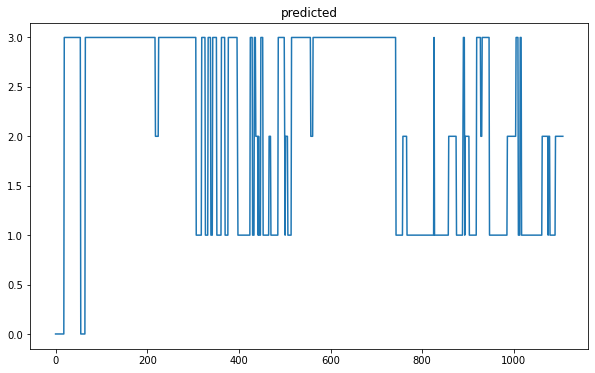

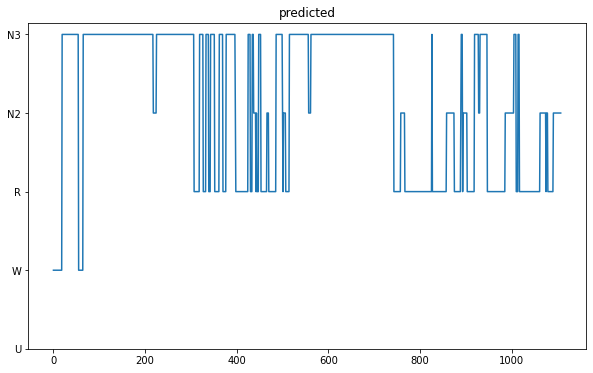

In [ ]:
#viz.plot_hypnogram(hypno_pred_val, smooth=5)
hypno_val = hypno_pred_val.replace(['U','W','R','N2','N3'],[-1,0,1,2,3])
c = viz.plot_hypnogram(hypno_val, smooth=8,title="predicted")
print(adjusted_rand_score(hypno_real,c[1:]))

c = pd.Series(data=c,index=np.arange(len(c)))
c = c.replace([-1,0,1,2,3],['U','W','R','N2','N3'])
c = viz.plot_labeled_hypnogram(c, title="predicted")
